# DS task
Начнём с импорта необходимых библиотек.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from string import ascii_letters, digits
from yellowbrick.text import FreqDistVisualizer
%matplotlib inline 

Сначала я думал делать запросы и скачивать html-доки через puppyterr, но остановился на том, что просто скачал 20 статей о диетических паттернах чтобы получился какой-никакой стартовый датасет.

В блоке, который идёт ниже, я запарсил html, находя и записывая названия статей и их абстракты для предстоящего анализа. 

In [2]:
N = 20
data = []
titles = []
urls = []
for i in range(N):
    filename = "data/"+str(i)+".html"
    urls.append(filename)
    f = open(filename, "r", encoding="utf-8")
    html_doc = f.read()
    soup = BeautifulSoup(html_doc, 'html.parser')
    div = soup.findAll('div', attrs={"class": "abstract-content selected"})
    for d in div:
        text = d.find('p').text
        text = text.strip()
        data.append(text)
    title = soup.find('h1', attrs={"class": "heading-title"})
    titles.append(title.text.strip())
    f.close()

Потом я "почистил" текст...

In [3]:
clear_data = []
allowed = set(ascii_letters + digits + ' ')
for t in data:
    tmptxt = ''.join(char for char in t if char in allowed)
    clear_data.append(tmptxt)

... и записал соответствующие столбцы в датафрейм.

In [4]:
df = pd.DataFrame(clear_data, columns=['Source'])
df["Article title"] = titles
df["URL"] = urls

Вот тут у меня возник первый вопрос: откуда взять *тренировочные* данные - статьи, у которых уже были бы лейблы про влияние диетических паттернов на рассеянный склероз?

Я сделал предположение, что каждая статья в датасете, в которой упоминаются различные диеты, имеет Score, в зависимости от влияния диет, про которые в них идёт речь, на склероз. Соответственно, статьи о диетических паттернах, которые не влияют на рассеянный склероз, имели бы Score равный 0, а статьи о влияющих диетах ‒ 1.

Ниже я составил возможный вектор Score.

In [5]:
y = [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]
df["Score"] = y

Далее идёт график распределения частот 10 самых популярных слов во всех статьях. Как и ожидалось, слово "sclerosis" среди них присутствует

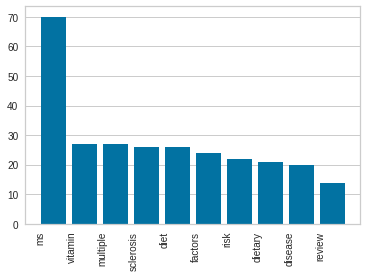

In [6]:
cv = CountVectorizer(stop_words='english')
docs = cv.fit_transform(df["Source"])
features = cv.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v', n=10)
visualizer.fit(docs);

Ниже я поделил данные на тренировочный и тестовый датасеты.

In [7]:
training_data, testing_data = train_test_split(df, random_state=777)
X_train = training_data["Source"]
y_train = training_data["Score"]
X_test = testing_data["Source"]
y_test = testing_data["Score"]

Для того чтобы можно было построить логистическую регрессию, нужно сделать выделение признаков. Я использовал технику TFIDF.

Также перед этим я убираю "stop words".

In [8]:
vectorizer = TfidfVectorizer(stop_words='english', use_idf=False)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

Наконец-то строю полиномиальную логистическую регрессию, делаю предикшн на тестовых данных и оцениваю качество модель при помощи accuracy_score и p-значения t-критерия Уэлча. Также вывожу odds ratio для всех коэффициентов модели.

In [9]:
clf = LogisticRegression().fit(train_vectors, y_train)
predicted = clf.predict(test_vectors)
print("LR Accuracy Score: ", accuracy_score(y_test, predicted))
print("OR: ", *np.exp(clf.coef_)[0][:3], "...")
print("P-value: ", stats.ttest_ind(y_test, predicted, equal_var = False).pvalue)

LR Accuracy Score:  0.8
OR:  0.976660923262188 0.9691144565120576 0.9691144565120576 ...
P-value:  0.373900966300059
